In [1]:
%load_ext autoreload
%autoreload 2

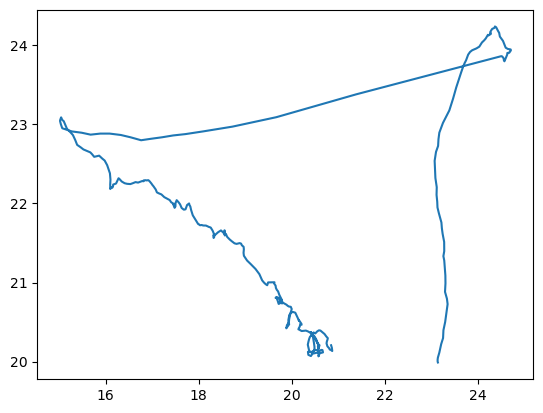

In [211]:
from pathlib import Path
import tifffile
import motionquant as mq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# list files from the src folder
src = Path('/media/cephfs2/jparham/For Jerome/Divisions with G2toConstriction/')
dst = Path('./')

filelist = pd.DataFrame.from_records(
    [{'path':f,'name':f.stem} for f in src.glob('[!.]*.tif')]
)
filelist.head()

filename = filelist['path'].iloc[1]
img = tifffile.imread(filename)
pimg = mq.preprocess(img, 100)
mask, position = mq.segment_and_track(pimg)
speed = np.diff(position, 1, axis=0)
plt.plot(position[2:,1], position[2:,0])

In [212]:
diff = mq.frame_differences(pimg[:,1])
flow = mq.compute_flow(pimg[:,1])
rho = mq.momentum(pimg[:-1,1], flow)
div = mq.divergence(rho)
print(diff.shape, flow.shape, rho.shape, div.shape)

(458, 1, 47, 47) (458, 2, 47, 47) (458, 2, 47, 47) (458, 1, 47, 47)


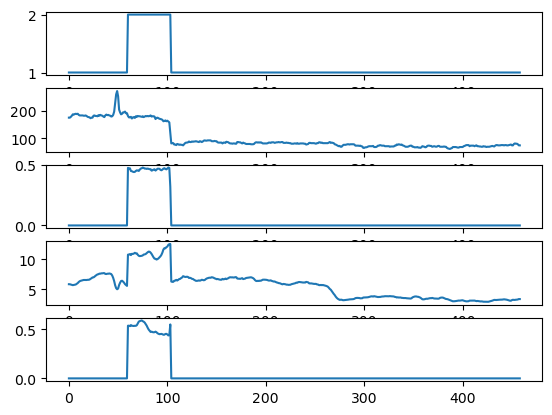

In [230]:
count, area, asymmetry_area, intensity, asymmetry_int, tmp = mq.blob_area_num_asymmetry(pimg[:,1], mask)

fig,ax = plt.subplots(5,1)
ax[0].plot(count)
ax[1].plot(area)
ax[2].plot(asymmetry_area)
ax[3].plot(intensity)
ax[4].plot(asymmetry_int)

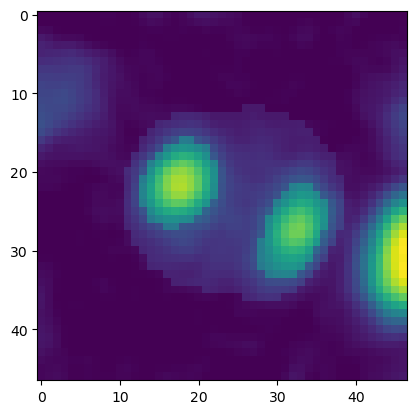

In [232]:
t = 100
plt.imshow(mask[t,0]+2*tmp[t] + pimg[t,1])

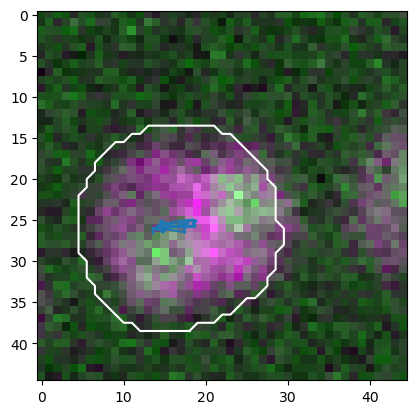

In [11]:
import matplotlib.pyplot as plt
from skimage import measure

plt.imshow(mq.uv2rgb(img[300]))
for c in measure.find_contours(mask[0, 0], 0.5):
        plt.plot(c[:, 1], c[:, 0], "w")
plt.plot(position[2:,1], position[2:,0])

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(15,5))
mq.figure(ax,"vv",img, mask, position, speed, diff, flow, rho, div)

In [ ]:
mq.strip(filename.stem, img, mask, position, speed, diff, flow, rho, div, "Greys", step=20, quiver=False)
plt.savefig('tmp.pdf')

In [ ]:
import napari
v = napari.view_image(img,channel_axis=1)
v.add_labels(mask.squeeze())
v.add_points(position,ndim=2)

In [ ]:
import colorsys
print(flow.max())

def vec2rgb(x):
    h = (np.arctan2(x[0],x[1])+3.1415) / (2*3.1415)
    v = np.linalg.norm(x,axis=0)    
    y = np.stack((h,v),-1).reshape(x.shape[1]*x.shape[2],2)         
    return np.stack([colorsys.hsv_to_rgb(hv[0],hv[1],1) for hv in y],0).reshape([x.shape[1],x.shape[2],3])

x,y = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))
plt.imshow(vec2rgb(np.stack((x,y))))
#plt.imshow(vec2rgb(flow[100]))
